In [38]:
import torch
import glob
from evaluation_functions import renyi_rankme, rankme
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [62]:
def get_features_for_ssl_method(ssl_method):
    features_files = glob.glob(f'representations/*/{ssl_method}/*')

    name_to_accuracies = {}
    name_to_features = {}
    name_to_targets = {}

    for features_file in tqdm.tqdm(features_files):
        try:
            name = features_file.split('/')[-1]
            accuracies = pd.read_csv(features_file + '/accuracies.csv')
            accuracies.drop(columns=['Unnamed: 0'], inplace=True)
            name_to_accuracies[name] = dict(accuracies)

            # get the features csv files and load them into a numpy array
            features_files = glob.glob(features_file + '/features/train*240.csv')


            df = pd.read_csv(features_files[0])
            df.drop(columns=['Index'], inplace=True)
            df = df.sample(frac=1).reset_index(drop=True)
            df = df.head(1000)

            if 'Target' not in df.columns:
                target = df.iloc[:, 0]
                features = df
            else:
                target = df['Target']
                features = df.drop(columns=['Target'])

            target = torch.tensor(target.values)
            features = torch.tensor(features.values)

            name_to_targets[name] = target
            name_to_features[name] = features
        except Exception as e:
            print(features_file, e)
            raise e

    return name_to_features, name_to_targets, name_to_accuracies

In [63]:
# calculate renyi rankme and rankme for each method
methods = ['bt', 'dino', 'mae', 'simclr']
method_to_metrics = {}

for method in methods:
    print(f'Calculating metrics for {method}')
    name_to_features, name_to_targets, name_to_accuracies = get_features_for_ssl_method(method)
    method_to_metrics[method] = {}
    for name in name_to_features:
        method_to_metrics[method][name] = {}
        method_to_metrics[method][name]['rankme'] = rankme(name_to_features[name])
        method_to_metrics[method][name]['renyi_rankme'] = renyi_rankme(name_to_features[name], alpha=2)

        for metric in name_to_accuracies[name]:
            method_to_metrics[method][name][metric] = name_to_accuracies[name][metric]


Calculating metrics for bt


100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Calculating metrics for dino


  0%|          | 0/12 [00:00<?, ?it/s]

representations/medianomaly/dino/sunny-dust-61 list index out of range


IndexError: list index out of range

In [15]:
float(method_to_metrics['bt']['frosty-firefly-28']['knn_f1'])

/tmp/ipykernel_3431359/1589384702.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(method_to_metrics['bt']['frosty-firefly-28']['knn_f1'])


0.8043068051338196

/tmp/ipykernel_3431359/1260340722.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ys = [float(method_to_metrics[method][name][y_var]) for name in method_to_metrics[method]]


KeyError: 'dino'

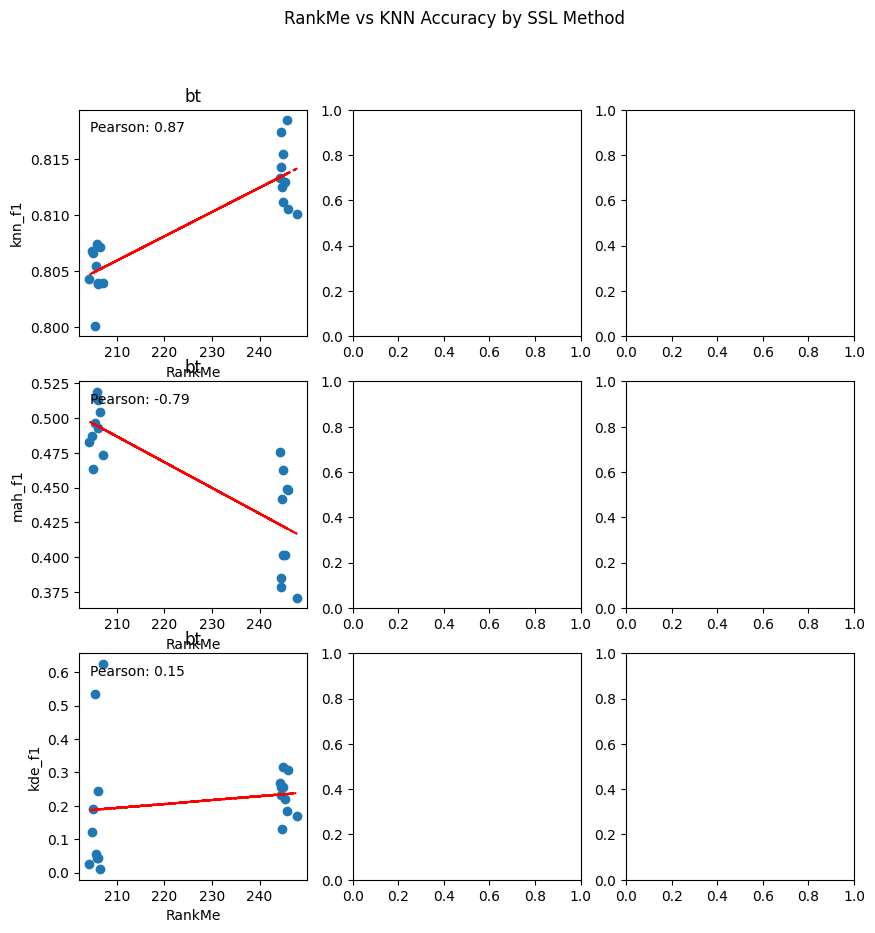

In [64]:
from scipy.stats import pearsonr

# create subplots for each method
methods = ['bt', 'dino', 'simclr']
fig, axes = plt.subplots(3, len(methods), figsize=(10, 10))
fig.suptitle('RankMe vs KNN Accuracy by SSL Method')

for method_idx, method in enumerate(methods):
    xs = [method_to_metrics[method][name]['rankme'] for name in method_to_metrics[method]]

    for y_var_idx, y_var in enumerate(['knn_f1', 'mah_f1', 'kde_f1']):
        ys = [float(method_to_metrics[method][name][y_var]) for name in method_to_metrics[method]]


        axes[y_var_idx, method_idx].scatter(xs, ys)



        axes[y_var_idx, method_idx].set_title(method)
        axes[y_var_idx, method_idx].set_xlabel('RankMe')
        axes[y_var_idx, method_idx].set_ylabel(y_var)

        # plot the trend line
        z = np.polyfit(xs, ys, 1)
        p = np.poly1d(z)
        axes[y_var_idx, method_idx].plot(xs, p(xs), "r--")

        # plot the pearson correlation coefficient
        r, _ = pearsonr(xs, ys)
        axes[y_var_idx, method_idx].text(0.05, 0.95, f'Pearson: {r:.2f}', transform=axes[y_var_idx, method_idx].transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.show()

In [30]:
# find all barlow twins names with rankme < 180
for name in method_to_metrics['bt']:
    if method_to_metrics['bt'][name]['rankme'] < 180:
        print(name)

# opposite
for name in method_to_metrics['bt']:
    if method_to_metrics['bt'][name]['rankme'] > 180:
        print('....', name)


frosty-firefly-28
wild-lake-29
comfy-pyramid-40
golden-puddle-27
worthy-night-36
generous-disco-26
deft-galaxy-39
blooming-flower-30
super-wave-37
dark-night-38
.... dutiful-armadillo-25
.... flowing-microwave-34
.... celestial-gorge-32
.... easy-jazz-35
.... stoic-pine-33
.... giddy-lion-22
.... glowing-puddle-21
.... youthful-sun-31
.... polar-disco-23
.... dazzling-monkey-24
